In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import sys

# Add src to path
sys.path.insert(0, './src')

In [20]:
# Import our modules
from config import *
from data_loader import load_dataset, save_modified_images, get_dataset_info
from feature_extractor import FeatureExtractor, create_feature_extractor
from frequency import create_bucket_masks, apply_weights_to_batch, get_frequency_spectrum
from metrics import compute_mmd, check_recognizability, compute_ssim_batch
from optimizer import run_optimization, compute_baseline_dissimilarity, OptimizationState
from visualization import (
    plot_loss_curves, plot_loss_curves_per_label, plot_weight_evolution,
    plot_before_after_comparison, plot_frequency_spectrum_comparison,
    plot_bucket_masks, plot_final_weights, plot_recognizability_metrics,
    save_iteration_snapshot
)

In [21]:
Path(OUTPUT_DIR).mkdir(exist_ok=True)
Path(f"{OUTPUT_DIR}/iterations").mkdir(exist_ok=True)
Path(f"{OUTPUT_DIR}/figures").mkdir(exist_ok=True)
Path(f"{OUTPUT_DIR}/modified_images").mkdir(exist_ok=True)

print(f"Ground truth: {GROUND_TRUTH_DIR}")
print(f"Custom data:  {CUSTOM_DIR}")
print(f"Output:       {OUTPUT_DIR}")

Ground truth: ground_truth_imgs
Custom data:  custom_imgs
Output:       outputs


In [22]:
print("Loading ground truth images...")
gt_images = load_dataset(GROUND_TRUTH_DIR, image_size=IMAGE_SIZE, grayscale=True, normalize=True)
gt_info = get_dataset_info(gt_images)
print(f"  Total: {gt_info['total_images']} images across {gt_info['num_classes']} classes")
print(f"  Image shape: {gt_info['image_shape']}")
print(f"  Value range: {gt_info['value_range']}")

print("\nLoading custom images...")
custom_images = load_dataset(CUSTOM_DIR, image_size=IMAGE_SIZE, grayscale=True, normalize=True)
custom_info = get_dataset_info(custom_images)
print(f"  Total: {custom_info['total_images']} images across {custom_info['num_classes']} classes")

Loading ground truth images...
  Loaded 99 images for label 0
  Loaded 99 images for label 1
  Loaded 100 images for label 2
  Loaded 100 images for label 3
  Loaded 100 images for label 4
  Loaded 100 images for label 5
  Loaded 100 images for label 6
  Loaded 100 images for label 7
  Loaded 100 images for label 8
  Loaded 100 images for label 9
  Total: 998 images across 10 classes
  Image shape: (128, 128)
  Value range: (np.float32(0.0), np.float32(1.0))

Loading custom images...
  Loaded 10 images for label 0
  Loaded 10 images for label 1
  Loaded 10 images for label 2
  Loaded 10 images for label 3
  Loaded 10 images for label 4
  Loaded 10 images for label 5
  Loaded 10 images for label 6
  Loaded 10 images for label 7
  Loaded 10 images for label 8
  Loaded 10 images for label 9
  Total: 100 images across 10 classes


Loading ground truth images...
  Loaded 99 images for label 0
  Loaded 99 images for label 1
  Loaded 100 images for label 2
  Loaded 100 images for label 3
  Loaded 100 images for label 4
  Loaded 100 images for label 5
  Loaded 100 images for label 6
  Loaded 100 images for label 7
  Loaded 100 images for label 8
  Loaded 100 images for label 9
  Total: 998 images across 10 classes
  Image shape: (128, 128)
  Value range: (np.float32(0.0), np.float32(1.0))

Loading custom images...
  Loaded 10 images for label 0
  Loaded 10 images for label 1
  Loaded 10 images for label 2
  Loaded 10 images for label 3
  Loaded 10 images for label 4
  Loaded 10 images for label 5
  Loaded 10 images for label 6
  Loaded 10 images for label 7
  Loaded 10 images for label 8
  Loaded 10 images for label 9
  Total: 100 images across 10 classes


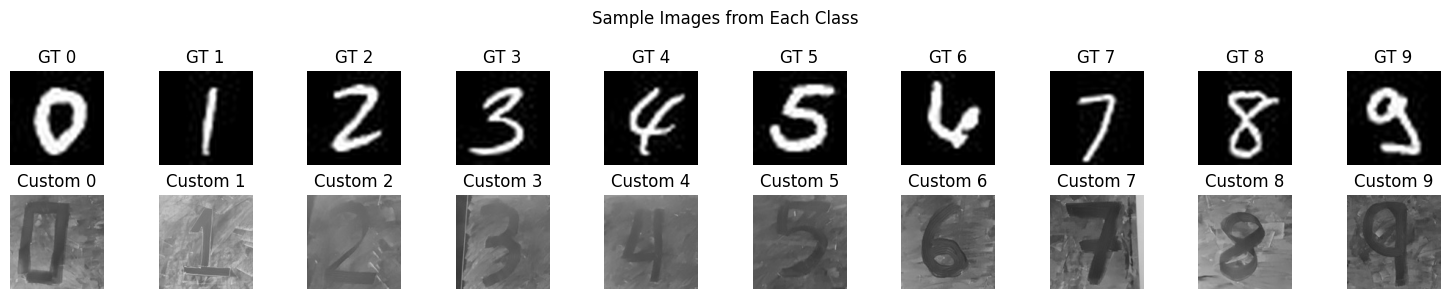

In [23]:
print("Loading ground truth images...")
gt_images = load_dataset(GROUND_TRUTH_DIR, image_size=IMAGE_SIZE, grayscale=True, normalize=True)
gt_info = get_dataset_info(gt_images)
print(f"  Total: {gt_info['total_images']} images across {gt_info['num_classes']} classes")
print(f"  Image shape: {gt_info['image_shape']}")
print(f"  Value range: {gt_info['value_range']}")

print("\nLoading custom images...")
custom_images = load_dataset(CUSTOM_DIR, image_size=IMAGE_SIZE, grayscale=True, normalize=True)
custom_info = get_dataset_info(custom_images)
print(f"  Total: {custom_info['total_images']} images across {custom_info['num_classes']} classes")

# =============================================================================
# CELL: Code - Display sample images
# =============================================================================
labels = sorted(gt_images.keys())
num_labels = len(labels)

fig, axes = plt.subplots(2, min(10, num_labels), figsize=(min(15, num_labels * 1.5), 3))
if num_labels == 1:
    axes = axes.reshape(2, 1)

for i, label in enumerate(labels[:10]):
    axes[0, i].imshow(gt_images[label][0], cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'GT {label}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(custom_images[label][0], cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Custom {label}')
    axes[1, i].axis('off')

plt.suptitle('Sample Images from Each Class')
plt.tight_layout()
plt.show()

Initializing feature extractor...
Loading MobileNetV2 on mps...
  Device: mps
  Feature dimension: 1280
Extracting ground truth features...
  Extracting features for label 0 (99 images)...
  Extracting features for label 1 (99 images)...
  Extracting features for label 2 (100 images)...
  Extracting features for label 3 (100 images)...
  Extracting features for label 4 (100 images)...
  Extracting features for label 5 (100 images)...
  Extracting features for label 6 (100 images)...
  Extracting features for label 7 (100 images)...
  Extracting features for label 8 (100 images)...
  Extracting features for label 9 (100 images)...
  Done! Feature shapes: (99, 1280)
Computing baseline dissimilarity (before optimization)...

Baseline MMD per label:
  Label 0: 0.8803
  Label 1: 0.8840
  Label 2: 0.8991
  Label 3: 0.9013
  Label 4: 0.9037
  Label 5: 0.8951
  Label 6: 0.8820
  Label 7: 0.8702
  Label 8: 0.8987
  Label 9: 0.9095
  Mean: 0.8924

Computing label prototypes (mean images)...


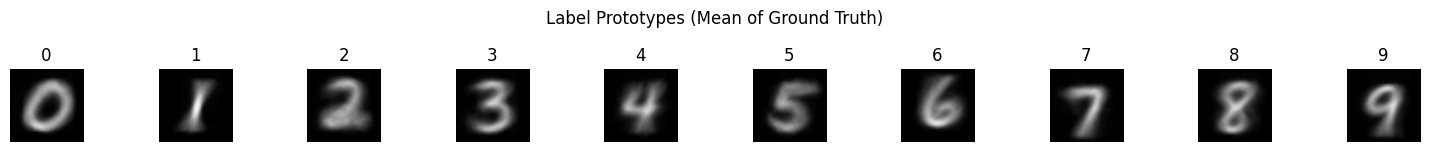

In [24]:
print("Initializing feature extractor...")
extractor = create_feature_extractor(device=DEVICE, input_size=FEATURE_INPUT_SIZE)
print(f"  Device: {extractor.device}")
print(f"  Feature dimension: {extractor.feature_dim}")

# =============================================================================
# CELL: Code - Extract ground truth features
# =============================================================================
print("Extracting ground truth features...")
gt_features = extractor.extract_all_labels(gt_images)
print(f"  Done! Feature shapes: {gt_features[labels[0]].shape}")

# =============================================================================
# CELL: Code - Compute baseline dissimilarity
# =============================================================================
print("Computing baseline dissimilarity (before optimization)...")
baseline_mmd = compute_baseline_dissimilarity(custom_images, gt_features, extractor)

print("\nBaseline MMD per label:")
for label in labels:
    print(f"  Label {label}: {baseline_mmd[label]:.4f}")
print(f"  Mean: {np.mean(list(baseline_mmd.values())):.4f}")

# =============================================================================
# CELL: Code - Compute prototypes
# =============================================================================
print("\nComputing label prototypes (mean images)...")
prototypes = {label: np.mean(gt_images[label], axis=0) for label in labels}

# Display prototypes
fig, axes = plt.subplots(1, min(10, num_labels), figsize=(min(15, num_labels * 1.5), 1.5))
if num_labels == 1:
    axes = [axes]

for i, label in enumerate(labels[:10]):
    axes[i].imshow(prototypes[label], cmap='gray', vmin=0, vmax=1)
    axes[i].set_title(f'{label}')
    axes[i].axis('off')

plt.suptitle('Label Prototypes (Mean of Ground Truth)')
plt.tight_layout()
plt.show()


Creating frequency bucket masks...
  Image size: 128x128
  Bucket boundaries: [0, 2, 4, 8, 16, 32, 64, 90]
  Number of buckets: 7


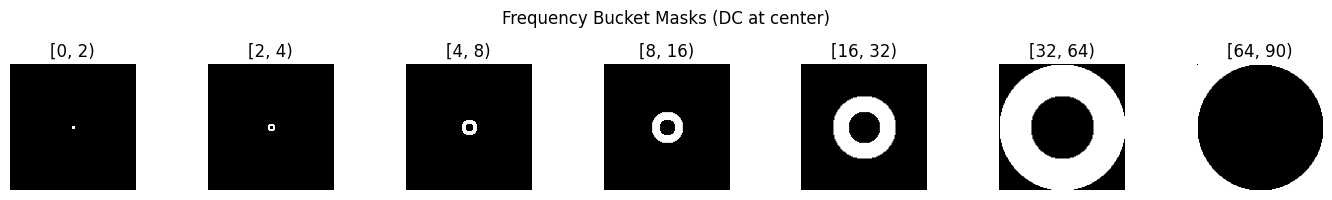

In [25]:
print(f"Creating frequency bucket masks...")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Bucket boundaries: {BUCKET_BOUNDARIES}")

bucket_masks = create_bucket_masks(image_size=IMAGE_SIZE, boundaries=BUCKET_BOUNDARIES)
print(f"  Number of buckets: {len(bucket_masks)}")

# Visualize bucket masks
plot_bucket_masks(bucket_masks, BUCKET_BOUNDARIES, f"{OUTPUT_DIR}/figures")

fig, axes = plt.subplots(1, len(bucket_masks), figsize=(len(bucket_masks) * 2, 2))
for i, mask in enumerate(bucket_masks):
    axes[i].imshow(mask.astype(float), cmap='gray')
    axes[i].set_title(f'[{BUCKET_BOUNDARIES[i]:.0f}, {BUCKET_BOUNDARIES[i+1]:.0f})')
    axes[i].axis('off')
plt.suptitle('Frequency Bucket Masks (DC at center)')
plt.tight_layout()
plt.show()

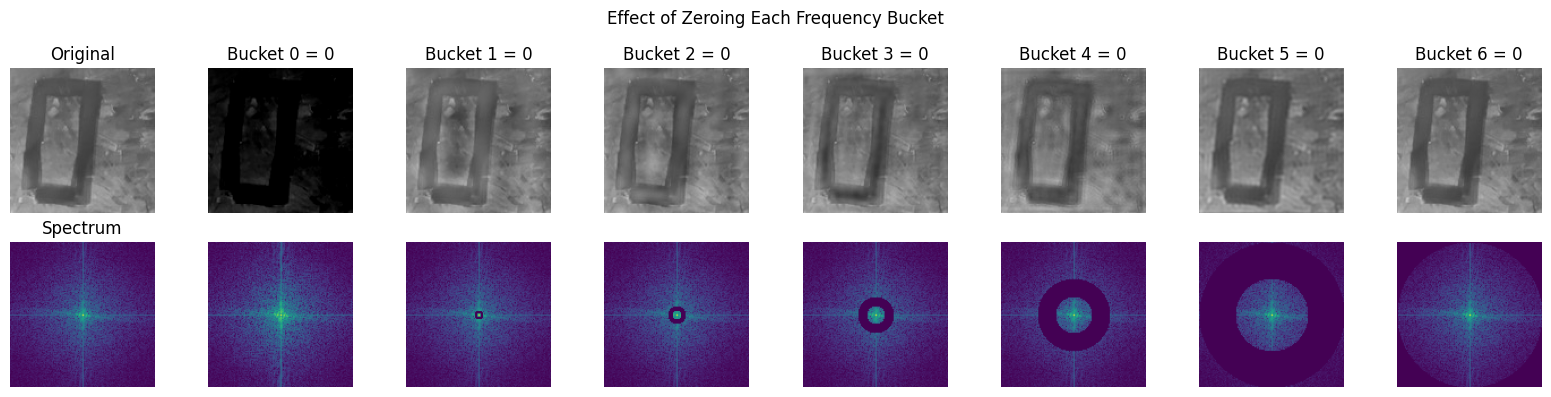

In [26]:
demo_label = labels[0]
demo_image = custom_images[demo_label][0]

fig, axes = plt.subplots(2, len(bucket_masks) + 1, figsize=((len(bucket_masks) + 1) * 2, 4))

# Original
axes[0, 0].imshow(demo_image, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

fft_orig = np.fft.fftshift(np.fft.fft2(demo_image))
axes[1, 0].imshow(np.log1p(np.abs(fft_orig)), cmap='viridis')
axes[1, 0].set_title('Spectrum')
axes[1, 0].axis('off')

# Effect of zeroing each bucket
for i in range(len(bucket_masks)):
    weights = np.ones(len(bucket_masks))
    weights[i] = 0.0  # Zero out this bucket
    
    modified = apply_weights_to_batch(demo_image[np.newaxis], weights, bucket_masks)[0]
    
    axes[0, i + 1].imshow(modified, cmap='gray', vmin=0, vmax=1)
    axes[0, i + 1].set_title(f'Bucket {i} = 0')
    axes[0, i + 1].axis('off')
    
    fft_mod = np.fft.fftshift(np.fft.fft2(modified))
    axes[1, i + 1].imshow(np.log1p(np.abs(fft_mod)), cmap='viridis')
    axes[1, i + 1].axis('off')

plt.suptitle('Effect of Zeroing Each Frequency Bucket')
plt.tight_layout()
plt.show()



In [27]:
print("Optimization settings:")
print(f"  Iterations: {NUM_ITERATIONS}")
print(f"  Learning rate: {LR_INITIAL} → {LR_FINAL} (log decay)")
print(f"  Epsilon (gradient estimation): {EPSILON}")
print(f"  Weight bounds: [{WEIGHT_MIN}, {WEIGHT_MAX}]")
print(f"\nRecognizability thresholds:")
print(f"  SSIM: >= {SSIM_THRESHOLD}")
print(f"  Low-freq correlation: >= {LOW_FREQ_CORRELATION_THRESHOLD}")
print(f"  Template matching: >= {TEMPLATE_MATCH_THRESHOLD}")

# =============================================================================
# CELL: Code - Run optimization
# =============================================================================
print("\n" + "="*60)
print("STARTING OPTIMIZATION")
print("="*60)

final_weights, optimization_state = run_optimization(
    custom_images_by_label=custom_images,
    gt_features_by_label=gt_features,
    prototypes=prototypes,
    bucket_masks=bucket_masks,
    feature_extractor=extractor,
    output_dir=OUTPUT_DIR,
    num_iterations=NUM_ITERATIONS,
    lr_initial=LR_INITIAL,
    lr_final=LR_FINAL,
    epsilon=EPSILON,
    weight_min=WEIGHT_MIN,
    weight_max=WEIGHT_MAX,
    ssim_threshold=SSIM_THRESHOLD,
    low_freq_threshold=LOW_FREQ_CORRELATION_THRESHOLD,
    template_threshold=TEMPLATE_MATCH_THRESHOLD,
    low_freq_cutoff=LOW_FREQ_CUTOFF_RADIUS,
    save_iterations=True,
)

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE")
print("="*60)


Optimization settings:
  Iterations: 85
  Learning rate: 1.0 → 0.01 (log decay)
  Epsilon (gradient estimation): 0.05
  Weight bounds: [0.1, 3.0]

Recognizability thresholds:
  SSIM: >= 0.6
  Low-freq correlation: >= 0.9
  Template matching: >= 0.9

STARTING OPTIMIZATION

Optimizing label 0...
  Iter  1: weights=array([1.00195742, 1.01242578, 0.99152958, 1.01310647, 0.89215255,
       1.06618917, 1.06086528]) {'ssim': 0.9977587461471558, 'low_freq_corr': 0.999999071579553, 'ssim_passed': True, 'low_freq_passed': True} MMD=0.8928, lr=1.0000
  Iter  2: weights=array([1.00326083, 1.02067171, 0.97012199, 1.04906547, 0.82737172,
       1.09558032, 1.05729528]) {'ssim': 0.9936542391777039, 'low_freq_corr': 0.9999964113181623, 'ssim_passed': True, 'low_freq_passed': True} MMD=0.9005, lr=0.9467
  Iter  3: weights=array([1.00362939, 1.02673695, 0.96136571, 1.05060595, 0.77670891,
       1.12452149, 1.061444  ]) {'ssim': 0.9898850202560425, 'low_freq_corr': 0.9999938587714718, 'ssim_passed': Tru

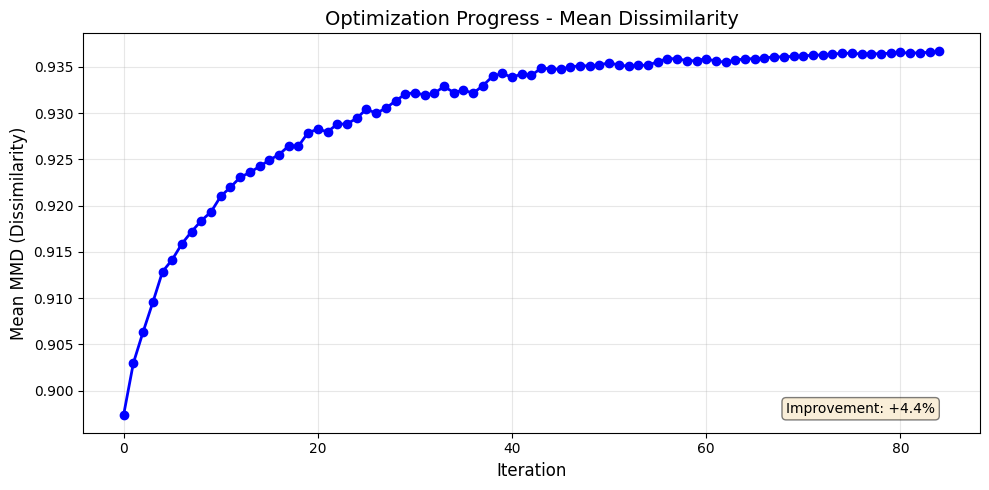

In [28]:
plot_loss_curves(optimization_state, f"{OUTPUT_DIR}/figures")

iterations = range(len(optimization_state.dissimilarity_history))
mean_dissim = [np.mean(list(d.values())) for d in optimization_state.dissimilarity_history]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(iterations, mean_dissim, 'b-o', linewidth=2, markersize=6)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Mean MMD (Dissimilarity)', fontsize=12)
ax.set_title('Optimization Progress - Mean Dissimilarity', fontsize=14)
ax.grid(True, alpha=0.3)

# Add improvement annotation
improvement = ((mean_dissim[-1] - mean_dissim[0]) / mean_dissim[0]) * 100
ax.annotate(f'Improvement: {improvement:+.1f}%', xy=(0.95, 0.05), xycoords='axes fraction',
            ha='right', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.savefig("../figs/mean_dissimilarity.png", dpi=300)


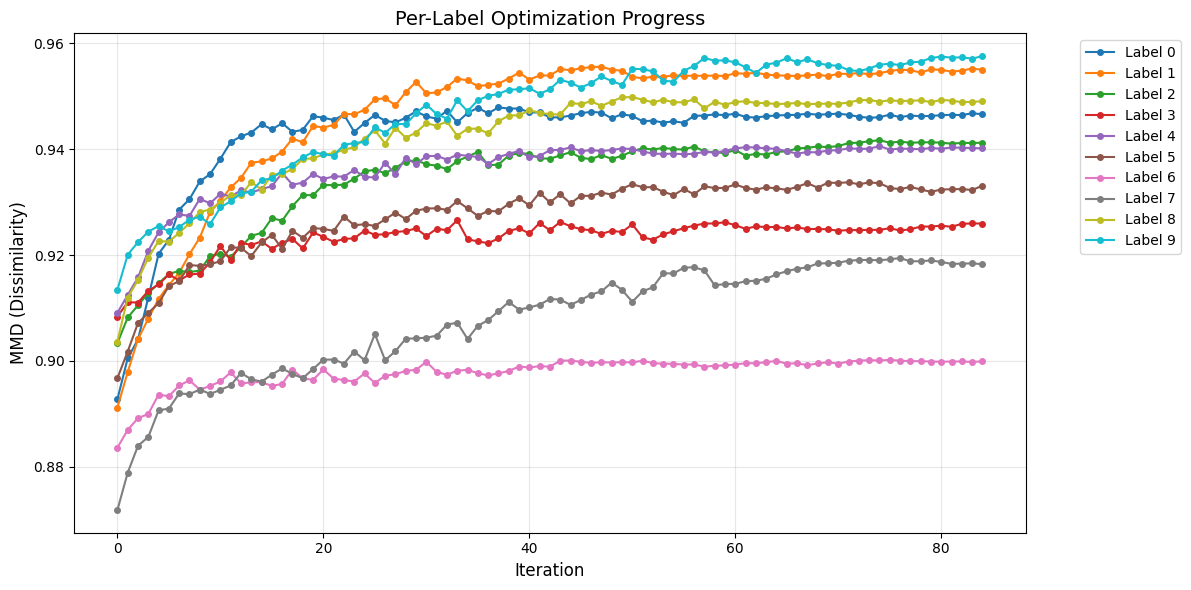

In [29]:
plot_loss_curves_per_label(optimization_state, f"{OUTPUT_DIR}/figures")

fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))

for label, color in zip(labels, colors):
    dissims = [h[label] for h in optimization_state.dissimilarity_history]
    ax.plot(iterations, dissims, '-o', color=color, label=f'Label {label}', 
            linewidth=1.5, markersize=4)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('MMD (Dissimilarity)', fontsize=12)
ax.set_title('Per-Label Optimization Progress', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../figs/per_label_dissimilarity.png", dpi=300)

In [30]:
plot_weight_evolution(optimization_state, f"{OUTPUT_DIR}/figures")

# Also plot final weights as bar chart
plot_final_weights(final_weights, BUCKET_BOUNDARIES, f"{OUTPUT_DIR}/figures")

# Display final weights
print("\nFinal optimized weights:")
print("-" * 60)
header = "Label  | " + " | ".join([f"B{i}" for i in range(len(bucket_masks))])
print(header)
print("-" * 60)
for label in labels:
    weights_str = " | ".join([f"{w:.2f}" for w in final_weights[label]])
    print(f"  {label}    | {weights_str}")



/Users/arjunsharma/development/caltech-classes-source/cs-148/project1/adversarial_mnist/visualization.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Final optimized weights:
------------------------------------------------------------
Label  | B0 | B1 | B2 | B3 | B4 | B5 | B6
------------------------------------------------------------
  0    | 1.06 | 1.14 | 0.67 | 0.84 | 0.28 | 1.18 | 1.06
  1    | 0.93 | 0.68 | 0.54 | 0.57 | 0.62 | 1.54 | 1.08
  2    | 0.95 | 1.25 | 0.56 | 0.53 | 0.78 | 1.34 | 1.06
  3    | 1.00 | 1.14 | 0.91 | 0.90 | 0.58 | 1.27 | 1.00
  4    | 0.84 | 0.89 | 0.64 | 0.48 | 0.66 | 1.16 | 1.10
  5    | 1.11 | 0.76 | 0.49 | 0.84 | 0.71 | 1.32 | 1.12
  6    | 1.11 | 0.85 | 0.69 | 1.02 | 0.77 | 1.16 | 1.05
  7    | 1.08 | 1.17 | 0.74 | 0.53 | 0.45 | 1.22 | 1.14
  8    | 1.22 | 0.99 | 0.66 | 0.87 | 0.36 | 0.83 | 1.20
  9    | 0.67 | 0.93 | 0.59 | 0.73 | 0.65 | 1.25 | 1.04


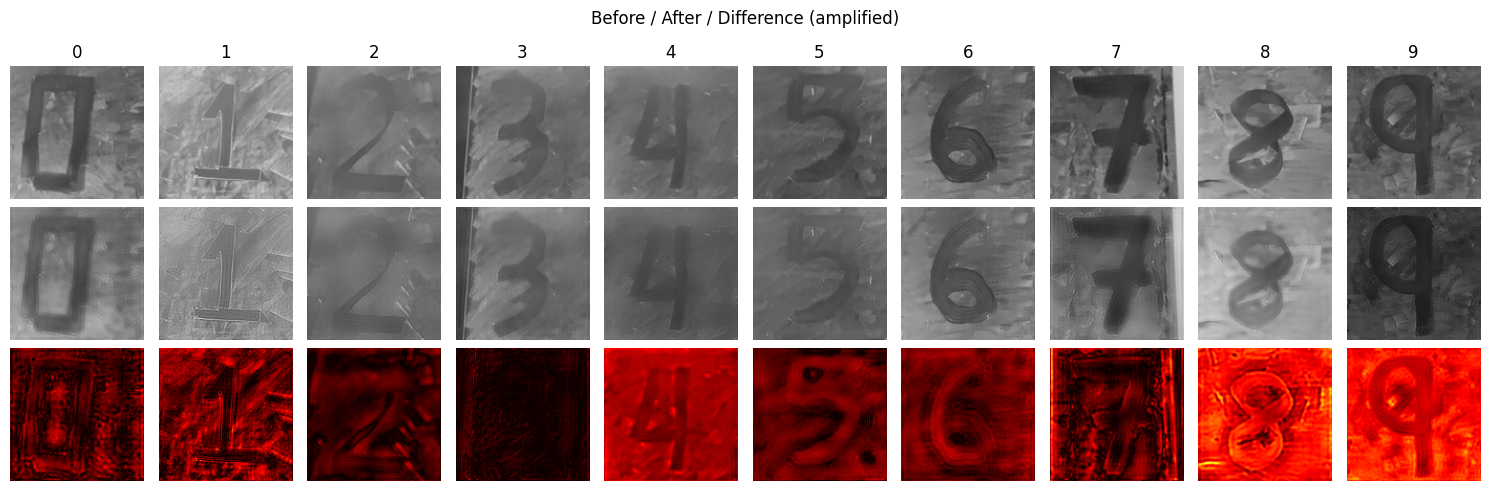

In [31]:
modified_images = {}
for label in labels:
    modified_images[label] = apply_weights_to_batch(
        custom_images[label], final_weights[label], bucket_masks
    )

# Save comparison figure
plot_before_after_comparison(custom_images, modified_images, f"{OUTPUT_DIR}/figures")

# Display inline
fig, axes = plt.subplots(3, min(10, num_labels), figsize=(min(15, num_labels * 1.5), 5))
if num_labels == 1:
    axes = axes.reshape(3, 1)

for i, label in enumerate(labels[:10]):
    axes[0, i].imshow(custom_images[label][0], cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'{label}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(modified_images[label][0], cmap='gray', vmin=0, vmax=1)
    axes[1, i].axis('off')
    
    diff = np.abs(custom_images[label][0] - modified_images[label][0])
    axes[2, i].imshow(diff, cmap='hot', vmin=0, vmax=0.3)
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Modified', fontsize=12)
axes[2, 0].set_ylabel('Difference', fontsize=12)

plt.suptitle('Before / After / Difference (amplified)')
plt.tight_layout()
plt.savefig("../figs/before_after_comparison.png", dpi=300)

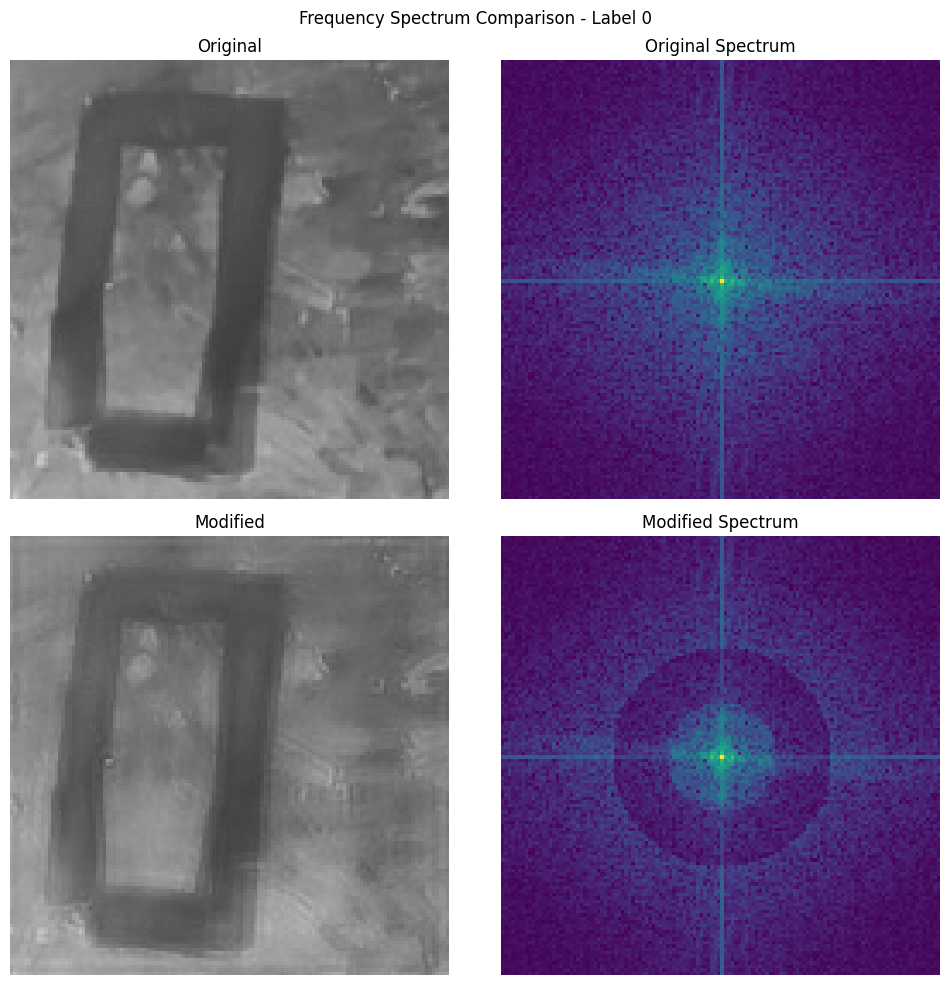

In [32]:
for label in labels[:3]:
    plot_frequency_spectrum_comparison(
        custom_images[label][0], 
        modified_images[label][0],
        f"{OUTPUT_DIR}/figures",
        label=label
    )

# Display one inline
label = labels[0]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(custom_images[label][0], cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

fft_orig = np.fft.fftshift(np.fft.fft2(custom_images[label][0]))
axes[0, 1].imshow(np.log1p(np.abs(fft_orig)), cmap='viridis')
axes[0, 1].set_title('Original Spectrum')
axes[0, 1].axis('off')

axes[1, 0].imshow(modified_images[label][0], cmap='gray', vmin=0, vmax=1)
axes[1, 0].set_title('Modified')
axes[1, 0].axis('off')

fft_mod = np.fft.fftshift(np.fft.fft2(modified_images[label][0]))
axes[1, 1].imshow(np.log1p(np.abs(fft_mod)), cmap='viridis')
axes[1, 1].set_title('Modified Spectrum')
axes[1, 1].axis('off')

plt.suptitle(f'Frequency Spectrum Comparison - Label {label}')
plt.tight_layout()
plt.savefig("../figs/frequency_spectrum_comparison.png", dpi=300)

In [33]:
print("="*60)
print("FINAL RESULTS")
print("="*60)

# Compute final dissimilarity
print("\nFinal MMD per label:")
final_mmd = {}
for label in labels:
    mod_features = extractor.extract(modified_images[label])
    final_mmd[label] = compute_mmd(gt_features[label], mod_features)
    improvement = ((final_mmd[label] - baseline_mmd[label]) / baseline_mmd[label]) * 100
    print(f"  Label {label}: {final_mmd[label]:.4f} (was {baseline_mmd[label]:.4f}, {improvement:+.1f}%)")

mean_baseline = np.mean(list(baseline_mmd.values()))
mean_final = np.mean(list(final_mmd.values()))
mean_improvement = ((mean_final - mean_baseline) / mean_baseline) * 100
print(f"\nMean: {mean_final:.4f} (was {mean_baseline:.4f}, {mean_improvement:+.1f}%)")



FINAL RESULTS

Final MMD per label:
  Label 0: 0.9466 (was 0.8803, +7.5%)
  Label 1: 0.9550 (was 0.8840, +8.0%)
  Label 2: 0.9412 (was 0.8991, +4.7%)
  Label 3: 0.9259 (was 0.9013, +2.7%)
  Label 4: 0.9401 (was 0.9037, +4.0%)
  Label 5: 0.9331 (was 0.8951, +4.2%)
  Label 6: 0.8999 (was 0.8820, +2.0%)
  Label 7: 0.9183 (was 0.8702, +5.5%)
  Label 8: 0.9490 (was 0.8987, +5.6%)
  Label 9: 0.9576 (was 0.9095, +5.3%)

Mean: 0.9367 (was 0.8924, +5.0%)


In [34]:
print("\\begin{tabular}{c c c c}")
print("\\toprule")
print("Label & Status & SSIM & Low-Freq Correlation \\\\")
print("\\midrule")

for label in labels:
    label_array = np.array([label] * len(modified_images[label]))
    passed, metrics = check_recognizability(
        custom_images[label], modified_images[label],
        label_array, prototypes,
        ssim_threshold=SSIM_THRESHOLD,
        low_freq_threshold=LOW_FREQ_CORRELATION_THRESHOLD,
        template_threshold=TEMPLATE_MATCH_THRESHOLD,
        low_freq_cutoff=LOW_FREQ_CUTOFF_RADIUS,
    )
    status = "Pass" if passed else "Fail"
    print(f"{label} & {status} & {metrics['ssim']:.4f} & {metrics['low_freq_corr']:.4f} \\\\")

print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{c c c c}
\toprule
Label & Status & SSIM & Low-Freq Correlation \\
\midrule
0 & Pass & 0.9090 & 0.9998 \\
1 & Pass & 0.9191 & 0.9997 \\
2 & Pass & 0.9343 & 0.9996 \\
3 & Pass & 0.9666 & 0.9999 \\
4 & Pass & 0.9302 & 0.9999 \\
5 & Pass & 0.9519 & 0.9996 \\
6 & Pass & 0.9721 & 0.9997 \\
7 & Pass & 0.9217 & 0.9999 \\
8 & Pass & 0.8980 & 0.9997 \\
9 & Pass & 0.8825 & 0.9993 \\
\bottomrule
\end{tabular}


In [35]:
print("\n" + "="*60)
print("SAVING OUTPUTS")
print("="*60)

# Save modified images
save_modified_images(modified_images, f"{OUTPUT_DIR}/modified_images", is_normalized=True)

# Save weights as numpy array
weights_array = np.array([final_weights[label] for label in labels])
print(weights_array)
np.save(f"{OUTPUT_DIR}/weights.npy", weights_array)
print(f"  Saved weights to {OUTPUT_DIR}/weights.npy")

# Also save as readable JSON
weights_dict = {str(label): final_weights[label].tolist() for label in labels}
with open(f"{OUTPUT_DIR}/weights.json", 'w') as f:
    json.dump(weights_dict, f, indent=2)
print(f"  Saved weights to {OUTPUT_DIR}/weights.json")

# Save optimization history
history = {
    'config': {
        'image_size': IMAGE_SIZE,
        'num_iterations': NUM_ITERATIONS,
        'lr_initial': LR_INITIAL,
        'lr_final': LR_FINAL,
        'epsilon': EPSILON,
        'weight_bounds': [WEIGHT_MIN, WEIGHT_MAX],
        'bucket_boundaries': BUCKET_BOUNDARIES,
        'ssim_threshold': SSIM_THRESHOLD,
        'low_freq_threshold': LOW_FREQ_CORRELATION_THRESHOLD,
        'template_threshold': TEMPLATE_MATCH_THRESHOLD,
    },
    'baseline_mmd': {str(k): float(v) for k, v in baseline_mmd.items()},
    'final_mmd': {str(k): float(v) for k, v in final_mmd.items()},
    'improvement_percent': float(mean_improvement),
    'dissimilarity_history': [
        {str(k): float(v) for k, v in d.items()} 
        for d in optimization_state.dissimilarity_history
    ],
    'learning_rates': optimization_state.learning_rates,
}

with open(f"{OUTPUT_DIR}/optimization_history.json", 'w') as f:
    json.dump(history, f, indent=2)
print(f"  Saved history to {OUTPUT_DIR}/optimization_history.json")

# Save full state
print(f"  Saved full state to {OUTPUT_DIR}/full_state.json")

print("\n" + "="*60)
print("DONE!")
print("="*60)
print(f"\nOutputs saved to: {OUTPUT_DIR}/")
print(f"  - modified_images/  : Modified images by label")
print(f"  - iterations/       : Per-iteration snapshots")
print(f"  - figures/          : All visualization figures")
print(f"  - weights.npy       : Final weights as numpy array")
print(f"  - weights.json      : Final weights as JSON")
print(f"  - optimization_history.json : Summary and history")




SAVING OUTPUTS
Saved 100 images to outputs/modified_images
[[1.06067948 1.1407197  0.67363104 0.83672179 0.28067238 1.17923435
  1.06278617]
 [0.92869244 0.68310977 0.53557669 0.5654705  0.6247575  1.53941262
  1.07662547]
 [0.954771   1.24616886 0.55592812 0.52677753 0.77795103 1.34195933
  1.05832817]
 [1.00288035 1.13506648 0.90876815 0.90484698 0.58340651 1.26752878
  1.00098115]
 [0.83910383 0.89140951 0.64030047 0.48406723 0.65800156 1.1556067
  1.10446949]
 [1.10689361 0.76090381 0.48546966 0.83771309 0.70698592 1.31578941
  1.12079562]
 [1.11081734 0.84633746 0.69323973 1.01803731 0.7726885  1.15521219
  1.0473156 ]
 [1.08060686 1.16928813 0.74257806 0.53098975 0.44896137 1.22369946
  1.13956101]
 [1.22249557 0.99022627 0.65766545 0.86749026 0.36187728 0.82983248
  1.19941229]
 [0.67469811 0.9276232  0.58511544 0.73480594 0.65092091 1.25186171
  1.0447913 ]]
  Saved weights to outputs/weights.npy
  Saved weights to outputs/weights.json
  Saved history to outputs/optimization_h

Found 85 iteration snapshots


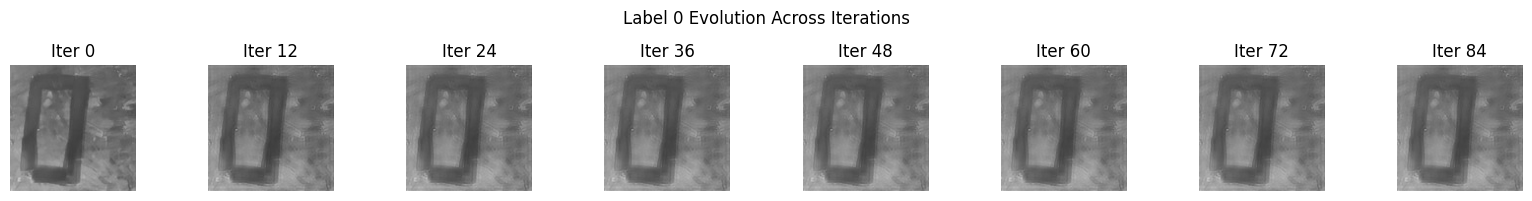

In [36]:
iter_dirs = sorted(Path(f"{OUTPUT_DIR}/iterations").glob("iter_*"))
print(f"Found {len(iter_dirs)} iteration snapshots")

if iter_dirs:
    # Show evolution of first label across iterations
    sample_label = labels[0]
    sample_iters = np.linspace(0, len(iter_dirs) - 1, min(8, len(iter_dirs)), dtype=int)
    
    fig, axes = plt.subplots(1, len(sample_iters), figsize=(len(sample_iters) * 2, 2))
    
    for idx, i in enumerate(sample_iters):
        # Load the snapshot
        iter_weights = optimization_state.weights_history[i][0]  # First label
        iter_images = apply_weights_to_batch(
            custom_images[sample_label], iter_weights, bucket_masks
        )
        
        axes[idx].imshow(iter_images[0], cmap='gray', vmin=0, vmax=1)
        axes[idx].set_title(f'Iter {i}')
        axes[idx].axis('off')
    
    plt.suptitle(f'Label {sample_label} Evolution Across Iterations')
    plt.tight_layout()
    plt.show()


In [37]:
TARGET_OUTPUT_DIR = "arjun_sharma"
Path(TARGET_OUTPUT_DIR).mkdir(exist_ok=True)
TARGET_OUTPUT_DIR =  "arjun_sharma/chalk_freq_edited"
Path(TARGET_OUTPUT_DIR).mkdir(exist_ok=True)

In [38]:
from PIL import Image
# go through every image in outputs/modified_images folder, and write images in the format {digit}_v{index}.jpg in resolution 128x128 to chalk_freq_edited directory
for label in labels:
    d = f"outputs/modified_images/{label}"
    for i, img_path in enumerate(Path(d).glob("*.png")):
        img = Image.open(img_path).convert("L")
        img = img.resize((128, 128))
        img.save(f"{TARGET_OUTPUT_DIR}/{label}_v{i+1}.jpg")
